#### Notebook Config

In [2]:
from IPython.core.display import display, HTML
from string import Template
import json, random
import networkx as nx
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,9)

/Users/rodtheo/Bioinfo/PROJETOS/entropyDBG/cdbgEnvironment/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [18]:
# import sys
# sys.path.append('/usr/local/lib/python2.7/site-packages')

In [ ]:
<html>
<head>
<style type="text/css">
  #container {
    max-width: 400px;
    height: 400px;
    margin: auto;
  }
</style>
</head>
<body>
<div id="container"></div>
<script src="sigma.min.js"></script>
<script src="sigma.parsers.json.min.js"></script>
<script>
  sigma.parsers.json('data.json', {
    container: 'container',
    settings: {
      defaultNodeColor: '#ec5148'
    }
  });
</script>
</body>
</html>

In [17]:
HTML('<script src="lib/sigma.min.js"></script>')
HTML('<script src="lib/sigma.parsers.json.min.js"></script>')

In [18]:
css_text = '''
#container {
    max-width: 400px;
    height: 400px;
    margin: auto;
  }
'''

In [19]:
js_text_template = Template(
    '''
    sigma.parsers.json("$python_data", {
    container: "$graphdiv",
    settings: {
      defaultNodeColor: "#ec5148"
    }
  });
  '''
)

In [20]:
json_data = open("sigma_ex.json").read()
data = json.loads(json_data)

In [22]:
html_template = Template('''
<style> $css_text </style>
<div id="container"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'container', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

In [29]:
from nbgraph.loaders.networkx_loader import load_graph
from nbgraph.renderer import display_notebook, prepare_notebook

G=nx.dodecahedral_graph()
display_notebook(load_graph(G), False) 

In [10]:
data

{u'edges': [{u'id': u'e0', u'source': u'n0', u'target': u'n1'},
  {u'id': u'e1', u'source': u'n1', u'target': u'n2'},
  {u'id': u'e2', u'source': u'n2', u'target': u'n0'}],
 u'nodes': [{u'id': u'n0', u'label': u'A node', u'size': 3, u'x': 0, u'y': 0},
  {u'id': u'n1', u'label': u'Another node', u'size': 2, u'x': 3, u'y': 1},
  {u'id': u'n2', u'label': u'And a last one', u'size': 1, u'x': 1, u'y': 3}]}

In [19]:
HTML('<script src="lib/d3/d3.min.js"></script>')

In [20]:
def replace_nodes(G0, Ns, N0):
    G0.add_node(N0, X="X")

    head = Ns[0]
    tail = Ns[-1]
    
    p = G0.predecessors(Ns[0])
    if len(p) == 1:
        p = p[0]
        G0.add_edge(p, N0)
        
    n = G0.successors(Ns[-1])
    if len(n) == 1:
        n = n[0]
        G0.add_edge(N0, n)
    
    G0.remove_nodes_from(Ns)

def reduce_graph(G0):
    G1 = G0.copy()
    G2 = G0.copy()
    nodes_to_remove = []
    for n in G1.nodes():
        if len(G1.successors(n)) > 1 or len(G1.predecessors(n)) > 1:
            if n[0] != "^" and n[-1] != "$":
                nodes_to_remove.append(n)
    G1.remove_nodes_from(nodes_to_remove)

    for ns in nx.weakly_connected_components(G1):
        print ns
        ns = [n for n in ns if n[0] != "^" and n[-1] != "$"]
        if len(ns) == 0: continue
        contig = []
        n_sorted = nx.topological_sort(G1, ns)
        n_sorted = [n for n in n_sorted if n[0] != "^" and n[-1] != "$"]
        if len(n_sorted) <= 1: continue

        for kmer in n_sorted:
            assert len(G1.successors(kmer)) <= 1
            if len(contig) == 0:
                contig.append(kmer)
            else:
                contig.append(kmer[-1])
        replace_nodes(G2, n_sorted, "".join(contig))
        
    return G2

Generate the JSON for the force layout.

In [21]:
def get_group(w, w1):
    c = 0
    for c1, c2 in zip(w,w1):
        if c1 == c2:
            c += 1
            continue
        break
    return c

def set_g_json(seq, k, color, reduce_g = False):
    G=nx.DiGraph()
    seq = "^"+seq+"$"
    for i in range(len(seq)-k+1):
        w1 = seq[i:i+k-1]
        w2 = seq[i+1:i+k]
        G.add_edge(w1, w2)
    if reduce_g == True:
        G = reduce_graph(G)
    def generateD3JSONForG(G, color):
        s = {"nodes":[], "links":[], "linksInteger":[]}
        name2Idx = {}
        c = 0
        for n in G.nodes():
            #print n
            g = len(G.neighbors(n))
            if "^" in n:
                s["nodes"].append({"name":n, "group":g, "fixed":True, "x":0,"y":150})
            elif "$" in n:
                s["nodes"].append({"name":n, "group":g, "fixed":True, "x":850,"y":150})
            else:
                s["nodes"].append({"name":n, "group":g})
            name2Idx[n] = c
            c += 1
        for e in G.edges():
            col = "rgb(0,0,255)"
            width = 1
            s["linksInteger"].append({"source":name2Idx[e[0]], "target":name2Idx[e[1]], "color":col, "width":width})
            s["links"].append({"source": e[0], "target": e[1], "type": color, "width":width})
#        return json.dumps(s)     
        return(s)
    n_json = generateD3JSONForG(G, color)
    return n_json


def buildDBG(seq, k, reduce_g = False):
    G=nx.DiGraph()
    assert(type(seq) == type(list()))
    for s in seq:
        s = "^"+s+"$"
        for i in range(len(s)-k+1):
            w1 = s[i:i+k-1]
            w2 = s[i+1:i+k]
            G.add_edge(w1, w2)
    if reduce_g == True:
        G = reduce_graph(G)
    return G
    #vis_cell.set_js_var("n_json", n_json)
   

In [22]:
dicSeqDummy1 = set_g_json("AATCGAGATAGA",5, "licensing", reduce_g=True)
dicSeqDummy2 = set_g_json("AATCGATATAGA",5, "suit", reduce_g=True)

['^AAT', 'CGAG', 'ATCG', 'TCGA', 'ATAG', 'AATC', 'GAGA', 'TAGA', 'AGAT', 'AGA$', 'GATA']
['^AAT', 'AGA$', 'CGAT', 'TCGA', 'TATA', 'ATAG', 'AATC', 'TAGA', 'ATCG', 'ATAT', 'GATA']


#### CSS and JavaScript based on bl.ocks example

Note that in the below css_text, we have removed the 'body' style reference from the original bl.ocks text. This is to avoid this style changing the rest of the notebook.

In [23]:
css_text = '''
path.link {
  fill: none;
  stroke: #666;
  stroke-width: 1.5px;
}

marker#licensing {
  fill: green;
}

path.link.licensing {
  stroke: green;
}

path.link.resolved {
  stroke-dasharray: 0,2 1;
}

circle {
  fill: #ccc;
  stroke: #333;
  stroke-width: 1.5px;
}

text {
  font: 10px sans-serif;
  pointer-events: none;
}

text.shadow {
  stroke: #fff;
  stroke-width: 3px;
  stroke-opacity: .8;
}
'''

The javascript below was copied directly from the bl.ocks script text, and then six lines were changed, as noted by // **** (the double-backslash is a comment in javascript, so these lines will not be executed). The first set of changes is to the width and height of the image. The second change is simply to reference a different DOM element as the starting point. The remaining changes are to replace the data-file reading step with a direct infusion of data into the script. (Note that the $ characters denote replacement points in the Template object.) 

In [24]:
js_text_template = Template('''
var margin = {top: 20, right: 20, bottom: 30, left: 40},
// ****    width = 960 - margin.left - margin.right, ****
// ****    height = 500 - margin.top - margin.bottom; ****
    width = 960 - margin.left - margin.right,
    height = 375 - margin.top - margin.bottom;

var x = d3.scale.linear()
    .range([0, width]);

var y = d3.scale.linear()
    .range([height, 0]);

var color = d3.scale.category10();

var xAxis = d3.svg.axis()
    .scale(x)
    .orient("bottom");

var yAxis = d3.svg.axis()
    .scale(y)
    .orient("left");

// **** var svg = d3.select("body").append("svg") ****
var svg = d3.select("#$graphdiv").append("svg")
    .attr("width", width + margin.left + margin.right)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

// **** d3.tsv("data.tsv", function(error, data) { ****
// ****  if (error) throw error; ****

var data = $python_data ;

  data.forEach(function(d) {
    d.sepalLength = +d.sepalLength;
    d.sepalWidth = +d.sepalWidth;
  });

  x.domain(d3.extent(data, function(d) { return d.sepalWidth; })).nice();
  y.domain(d3.extent(data, function(d) { return d.sepalLength; })).nice();

  svg.append("g")
      .attr("class", "x axis")
      .attr("transform", "translate(0," + height + ")")
      .call(xAxis)
    .append("text")
      .attr("class", "label")
      .attr("x", width)
      .attr("y", -6)
      .style("text-anchor", "end")
      .text("Sepal Width (cm)");

  svg.append("g")
      .attr("class", "y axis")
      .call(yAxis)
    .append("text")
      .attr("class", "label")
      .attr("transform", "rotate(-90)")
      .attr("y", 6)
      .attr("dy", ".71em")
      .style("text-anchor", "end")
      .text("Sepal Length (cm)")

  svg.selectAll(".dot")
      .data(data)
    .enter().append("circle")
      .attr("class", "dot")
      .attr("r", 3.5)
      .attr("cx", function(d) { return x(d.sepalWidth); })
      .attr("cy", function(d) { return y(d.sepalLength); })
      .style("fill", function(d) { return color(d.species); });

  var legend = svg.selectAll(".legend")
      .data(color.domain())
    .enter().append("g")
      .attr("class", "legend")
      .attr("transform", function(d, i) { return "translate(0," + i * 20 + ")"; });

  legend.append("rect")
      .attr("x", width - 18)
      .attr("width", 18)
      .attr("height", 18)
      .style("fill", color);

  legend.append("text")
      .attr("x", width - 24)
      .attr("y", 9)
      .attr("dy", ".35em")
      .style("text-anchor", "end")
      .text(function(d) { return d; });

// **** }); ****

''')

In [25]:
js_text_template = Template('''

// http://blog.thomsonreuters.com/index.php/mobile-patent-suits-graphic-of-the-day/
var links = $python_data;

//sort links by source, then target
links.sort(function(a,b) {
    if (a.source > b.source) {return 1;}
    else if (a.source < b.source) {return -1;}
    else {
        if (a.target > b.target) {return 1;}
        if (a.target < b.target) {return -1;}
        else {return 0;}
    }
});

//any links with duplicate source and target get an incremented 'linknum'
for (var i=0; i<links.length; i++) {
    if (i != 0 &&
        links[i].source == links[i-1].source &&
        links[i].target == links[i-1].target) {
            links[i].linknum = links[i-1].linknum + 1;
        }
    else {links[i].linknum = 1;};
};

var nodes = {};

// Compute the distinct nodes from the links.
links.forEach(function(link) {
  link.source = nodes[link.source] || (nodes[link.source] = {name: link.source});
  link.target = nodes[link.target] || (nodes[link.target] = {name: link.target});
});

var w = 600,
    h = 600;

var force = d3.layout.force()
    .nodes(d3.values(nodes))
    .links(links)
    .size([w, h])
    .linkDistance(60)
    .charge(-300)
    .on("tick", tick)
    .start();

var svg = d3.select("#$graphdiv").append("svg")
    .attr("width", w)
    .attr("height", h);

// Per-type markers, as they don't inherit styles.
svg.append("svg:defs").selectAll("marker")
    .data(["suit", "licensing", "resolved"])
  .enter().append("svg:marker")
    .attr("id", String)
    .attr("viewBox", "0 -5 10 10")
    .attr("refX", 15)
    .attr("refY", -1.5)
    .attr("markerWidth", 6)
    .attr("markerHeight", 6)
    .attr("orient", "auto")
  .append("svg:path")
    .attr("d", "M0,-5L10,0L0,5");

var path = svg.append("svg:g").selectAll("path")
    .data(force.links())
  .enter().append("svg:path")
    .attr("class", function(d) { return "link " + d.type; })
    .attr("marker-end", function(d) { return "url(#" + d.type + ")"; });

var circle = svg.append("svg:g").selectAll("circle")
    .data(force.nodes())
  .enter().append("svg:circle")
    .attr("r", 6)
    .call(force.drag);

var text = svg.append("svg:g").selectAll("g")
    .data(force.nodes())
  .enter().append("svg:g");

// A copy of the text with a thick white stroke for legibility.
text.append("svg:text")
    .attr("x", 8)
    .attr("y", ".31em")
    .attr("class", "shadow")
    .text(function(d) { return d.name; });

text.append("svg:text")
    .attr("x", 8)
    .attr("y", ".31em")
    .text(function(d) { return d.name; });

// Use elliptical arc path segments to doubly-encode directionality.
function tick() {
  path.attr("d", function(d) {
    var dx = d.target.x - d.source.x,
        dy = d.target.y - d.source.y,
        dr = 75/d.linknum;  //linknum is defined above
    return "M" + d.source.x + "," + d.source.y + "A" + dr + "," + dr + " 0 0,1 " + d.target.x + "," + d.target.y;
  });

  circle.attr("transform", function(d) {
    return "translate(" + d.x + "," + d.y + ")";
  });

  text.attr("transform", function(d) {
    return "translate(" + d.x + "," + d.y + ")";
  });
  
}

''')

#### And finally, the viz

## Typical structures in de bruijn graphs arising from genetic variantion.

# Simple SNP (clean bubble)

The graph is a colored de bruijn graph containing 3 individuals. The sequence was broken down into 7-mers. This example shows a bubble of length k representing a clean SNP.

In [26]:
# The yield MSA is represented bellow:
#read_1          TACACGTCGGCACATCGGATACA
#read_2          TACACGTCTGCACATCG------
#ref             TACACGTCAGCACATCGGATACA
#                ******** *******    

dicSeqDummy1 = set_g_json("TACACGTCGGCACATCG",8, "licensing")
dicSeqDummy2 = set_g_json("TACACGTCTGCACATCG",8, "suit")
dicSeqRef =    set_g_json("TACACGTCAGCACATCG",8, "resolved")

### Effects of branching bubbles in graph

In discoSNP paper the authors showed four possible branching bubbles.

![](images/discosnp.png)

The first case that we're checking is related to non-symetrically branching bubbles. The sequences used to demonstrate the graph are not the same as the sequences used in figure bellow.

We have three paths corresponding to first bubble (top and bottom path) and branching bubble (higher top path) mimic figure 3(a).

In [27]:
from Bio.Seq import Seq

dummy1 = Seq("TACACGTCGGCACATCG")
dummy2 = Seq("TACACGTCTGCACATCG")
ref = Seq("TACACGTCGTCACATCG")

dummy1Rev = str(dummy1.reverse_complement())
dummy1Rev

'CGATGTGCCGACGTGTA'

In [28]:
# "TACACGTCGGCACATCG","TACACGTCTGCACATCG","TACACGTCTTCACATCG"
# Check variant in position 9 -----** and a second variant in position 10 branching from two alleles (Dummy1 and Dummy3)
# The Dummy1 is colored in green and Dummy2 has black line while branching variants are dashed lines
dicSeqDummy1 = set_g_json(str(dummy1),8, "licensing")
dicSeqDummy2 = set_g_json(str(dummy2),8, "suit")
dicSeqRef =    set_g_json(str(ref),8, "resolved")

In [29]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2 + dataRef)

fake = set_g_json("ACGTACGTTGTGCAGTAGTAGTAGT",5,"licensing")
data = json.dumps(fake['links'])

In [30]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

In [343]:
# "TACACGTCGGCACATCG","TACACGTCTGCACATCG","TACACGTCTTCACATCG"
# Check variant in position 9 -----** and a second variant in position 10 branching from two alleles (Dummy1 and Dummy3)
# The Dummy1 is colored in green and Dummy2 has black line while branching variants are dashed lines
dicSeqDummy1 = set_g_json(str(dummy1.reverse_complement()),8, "licensing")
dicSeqDummy2 = set_g_json(str(dummy2.reverse_complement()),8, "suit")
dicSeqRef =    set_g_json(str(ref.reverse_complement()),8, "resolved")

dataDummy1Rev = dicSeqDummy1['links']
dataDummy2Rev = dicSeqDummy2['links']
dataRefRev = dicSeqRef['links']

dataRev = json.dumps(dataDummy1Rev + dataDummy2Rev + dataRefRev)

html_template = Template('''
<style> $css_text </style>
<div id="graph-div-rev"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-rev', 'python_data': dataRev})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

In [255]:
GA = buildDBG(["TACACGTCGGCACATCG","TACACGTCTGCACATCG"], 7)
adj = nx.to_numpy_matrix(GA)

In [256]:
def return_target_source(GA):
    t = list()
    s = list()
    for idx in xrange(len(GA.nodes())):
        target_list = GA.adjacency_list()[idx]
        for x in xrange(len(target_list)):
            s.append(GA.nodes()[idx])
        for tnode in target_list:
            t.append(tnode)
    return(s,t)
    

## Graph Entropy

### Tutzauer metric

Given the example in Tutzauer (2007) showing the gang alliance network with a undirected graph lets implement the functions to measure its entropy. The nodes in the graph have the same name as in authors paper.

In [257]:
G = nx.Graph()
G.add_edge(1,2)
G.add_edge(2,3)
G.add_edge(3,5)
G.add_edge(5,4)
G.add_edge(5,6)
G.add_edge(6,7)
G.add_edge(7,10)
G.add_edge(7,8)
G.add_edge(8,10)
G.add_edge(8,9)
G.add_edge(9,10)
G.add_edge(10,11)

![](images/tutzauer-graph.png)

In [258]:
def downstream_degree(node, path, G):
    """
    Finds the downstream degree D(vt) of node vt.
    It is the total number of edges incident with vt (i.e., its degree)
    subtracted from total number of edges incident with
    vertices appearing earlier in path (Tutzauer, 2007)
    
    Params:
    --------
    
    G    : graph (undirected graph)
    node : query node object
    path : list that contains the name of nodes forming a path
    
    Returns:
    --------
    
    The downstream (D(vt)) degree of input node
    
    """
    nodeDegree = G.degree(node)
    idx = [item for item in range(len(path)) if path[item] == node][0]
    n=0
    sumPre = 0
    while(node != path[n]):
        if G.has_edge(path[n],node):
            sumPre += 1
        n+=1
    return nodeDegree - sumPre + 1

def find_all_paths2(graph, start, end, vn = []):
        """ 
        Finds all paths between nodes start and end in graph.
        If any node on such a path is within vn, the path is not         
        returned.
        !! start and end node can't be in the vn list !!

        Params:
        --------

        G : igraph graph

        start: start node index

        end : end node index

        vn : list of via- or stop-nodes indices

        Returns:
        --------

        A list of paths (node index lists) between start and end node
        """
        vn = vn if type(vn) is list else [vn]
        path  = []
        paths = []
        queue = [(start, end, path)]
        while queue:
            start, end, path = queue.pop()
            #print 'PATH', path
            path = path + [start]
            #print 'PATH after adding start ', path
            if start in vn:
               # print start,' is in vianodes ',str(vn)
                pass #paths.append(path)
            if start == end:
               # print 'end'
                paths.append(path)
            #print graph.neighbors(start)
            if start not in vn:
               # print start,' not in vianodes ',str(vn)
                for node in set(graph.neighbors(start)).difference(path):
                    queue.append((node, end, path))
        return paths
    
def pij(nodeBegin, nodeEnd, G):
    """ 
    Calculates the entropy of every path between a specified start
    and end node (i.e, nodeBegin and nodeEnd). The entropy of a path P
    is the multiplication of every node transfer probability which is 
    the inverse of downstream edge (1/D(vt) that traverses P. 
    path is 

    Params:
    --------

    G : undirected Graph

    nodeBegin: start node object

    nodeEng : end node object

    Returns:
    --------

    The path probabilities summed across the K(i,j) paths from i to j given
    that the stop probability sigma is 1/D(vt)
    """
    pij = 0
    paths = find_all_paths2(G,nodeBegin,nodeEnd,[])
    for p in paths:
        #print(p)
        pij_p = 1
        for n in p:
            pij_p = pij_p * downstream_degree(n,p,G)
        #print(pij_p)
        pij += 1./pij_p
    #print "PIJ: ", pij
    return pij

def path_transfer(node, G):
    """ 
    Finds the path-transfer centrality of node given
    the graph G

    Params:
    --------

    G : undirected Graph

    node : query node (vt)

    Returns:
    --------

    The path-transfer centrality C_H(vt)
    """
    ch =0
    for n in nx.nodes(G):
        p_in = pij(node, n, G)
        if p_in != 0:
            ch -= (p_in * np.log2(p_in))
    return ch
    

In [259]:
print path_transfer(6,G)

3.02828722796


Showing a more general example (section 6) of Tutzauer, et al 2007 paper. Its a modification taking the earlier graph and turning it into a directed graph and a unconected hub (nodes 12, 13, 14, 15). You can see the resulting digraph bellow.

![](images/tutzauer-digraph.png)

In [260]:
G=nx.DiGraph()

G.add_edge(1,2,weight=1)
G.add_edge(2,1,weight=2)
G.add_edge(2,3,weight=2)
G.add_edge(3,2,weight=3)
G.add_edge(3,5,weight=2)
G.add_edge(5,4,weight=8)
G.add_edge(5,6,weight=9)
G.add_edge(7,6,weight=4)
G.add_edge(7,8,weight=4)
G.add_edge(8,9,weight=1)
G.add_edge(9,10,weight=2)
G.add_edge(8,10,weight=3)
G.add_edge(10,7,weight=5)
G.add_edge(10,11,weight=8)
G.add_edge(12,13,weight=3)
G.add_edge(13,14,weight=1)
G.add_edge(14,12,weight=2)
G.add_edge(15,14,weight=4)
G.add_edge(14,16,weight=4)



In [261]:
def downstream_degree_DAG(node,path, G, w=None):
    """
    Finds the downstream degree D(vt) of node vt.
    It us tge total number of edges incident with vt (i.e., its degree)
    subtract from total number of edges incident with
    vertices appearing earlier in path
    """
     
    nodeDegree = G.out_degree(node, weight=w)
    idx = [item for item in range(len(path)) if path[item] == node][0]
    n=0
    sumPre = nodeDegree
    in_nodes = [i for i,o in G.in_edges(node)]
    out_nodes = [j for ni,j in G.out_edges(node)]
    print "out: ", out_nodes
    pij=1
    while(n <= idx): # the path must be sorted in topological order
        if (path[n] == node):
            if (len(path) != 1):
                if (idx < len(path)-1):
                    weight_j = G.get_edge_data(node, path[n+1], default=0)
                    if weight_j != 0:
                        numerator = float(weight_j[w])
                else:
                        return (1.0,nodeDegree,"sigma")
            else:
                #if (n == 0) and (len(out_nodes) == 0):
                if (n == 0) and (len(out_nodes) == 0):
                    return (0,0,0)
                else:
                    numerator = 1.0
        if path[n] != node:
            if path[n] in in_nodes:
                #sumPre -= G.get_edge_data(node, path[n], default=0)
                weight = G.get_edge_data(path[n], node, default=0)
                if weight != 0:
                    sumPre -= weight[w]
        n+=1
    return (numerator, nodeDegree, sumPre )

def sigma(node, D, G):
    if D == 0:
        return 1
    else:
        a_vt = 1.0
        return (a_vt/D)
    
#     print "out_nodes:", out_nodes
#     if nodej in out_nodes:
#         weight_j = G.get_edge_data(node, nodej, default=0)
#         wj = weight_j[w]
#         return (float(wj),sumPre,nodeDegree)
#     else:
#         return (1., sumPre,nodeDegree)

    
    

def pij(nodeBegin, nodeEnd, G):
    pij = 0
    paths = find_all_paths2(G,nodeBegin,nodeEnd,[])
    for p in paths:
        print "PATH: ", p
        pij_p = 1
        for n in xrange(len(p)):
            numerator, D, _ = downstream_degree_DAG(p[n],p,G,w='weight')
            print numerator, D
            # last node
            if n == (len(p)-1):
                print "ultimo no testado: ", p[n]
                #if (D == 4) or (D==0):
                if (D==0):
                    pij_p *= 1
                else:
                    pij_p *= (numerator/D)
            else:
                print "no testado: ", p[n]
                tal_k = numerator/D
                pij_p *= tal_k
        print("pij_p:", pij_p)
        #pij += 1./pij_p
        pij += pij_p
    print "PIJ: ", pij
    return pij

def path_transfer(node, G):
    ch =0
    for n in nx.nodes(G):
        p_in_for = pij(node, n, G)
        #p_in_inv = pij(n, node, G)
        if (p_in_for != 0):
            ch -= (p_in_for * np.log2(p_in_for))
        #if p_in_inv != 0:
        #    ch -= (p_in_inv * np.log2(p_in_inv))
    return ch

In [262]:
print downstream_degree_DAG(1, [2,1], G, w='weight')

out:  [2]
(1.0, 1, 'sigma')


In [263]:
print path_transfer(15, G)

PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PATH:  [15, 14, 12]
out:  [14]
4.0 4
no testado:  15
out:  [16, 12]
2.0 6
no testado:  14
out:  [13]
1.0 3
ultimo no testado:  12
('pij_p:', 0.1111111111111111)
PIJ:  0.111111111111
PATH:  [15, 14, 12, 13]
out:  [14]
4.0 4
no testado:  15
out:  [16, 12]
2.0 6
no testado:  14
out:  [13]
3.0 3
no testado:  12
out:  [14]
1.0 1
ultimo no testado:  13
('pij_p:', 0.3333333333333333)
PIJ:  0.333333333333
PATH:  [15, 14]
out:  [14]
4.0 4
no testado:  15
out:  [16, 12]
1.0 6
ultimo no testado:  14
('pij_p:', 0.16666666666666666)
PIJ:  0.166666666667
PATH:  [15]
out:  [14]
1.0 4
ultimo no testado:  15
('pij_p:', 0.25)
PIJ:  0.25
PATH:  [15, 14, 16]
out:  [14]
4.0 4
no testado:  15
out:  [16, 12]
4.0 6
no testado:  14
out:  []
1.0 0
ultimo no testado:  16
('pij_p:', 0.6666666666666666)
PIJ:  0.666666666667
2.20133680656


In [264]:
results = []
for x in range(1,16):
    results.append((x, path_transfer(x, G)))

PATH:  [1]
out:  [2]
1.0 1
ultimo no testado:  1
('pij_p:', 1.0)
PIJ:  1.0
PATH:  [1, 2]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
1.0 4
ultimo no testado:  2
('pij_p:', 0.25)
PIJ:  0.25
PATH:  [1, 2, 3]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
2.0 4
no testado:  2
out:  [2, 5]
1.0 5
ultimo no testado:  3
('pij_p:', 0.1)
PIJ:  0.1
PATH:  [1, 2, 3, 5, 4]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
2.0 4
no testado:  2
out:  [2, 5]
2.0 5
no testado:  3
out:  [4, 6]
8.0 17
no testado:  5
out:  []
1.0 0
ultimo no testado:  4
('pij_p:', 0.09411764705882353)
PIJ:  0.0941176470588
PATH:  [1, 2, 3, 5]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
2.0 4
no testado:  2
out:  [2, 5]
2.0 5
no testado:  3
out:  [4, 6]
1.0 17
ultimo no testado:  5
('pij_p:', 0.011764705882352941)
PIJ:  0.0117647058824
PATH:  [1, 2, 3, 5, 6]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
2.0 4
no testado:  2
out:  [2, 5]
2.0 5
no testado:  3
out:  [4, 6]
9.0 17
no testado:  5
out:  []
1.0 0
ultimo no testado:  6
('pi

In [265]:
results_sorted = sorted(results, key=lambda x:x[1], reverse=True)
results_sorted

[(3, 2.4510721795875079),
 (8, 2.2586004835336722),
 (7, 2.2039983639719165),
 (15, 2.2013368065571615),
 (9, 2.0941058500362555),
 (2, 2.071483536988711),
 (10, 1.7233969948260082),
 (14, 1.7013368065571615),
 (1, 1.5714835369887108),
 (12, 1.3491229175080157),
 (5, 1.2379415370308999),
 (13, 1.1730159729834426),
 (4, 0.0),
 (6, 0.0),
 (11, 0.0)]

In [266]:
def entropy(p):
    return -p*np.log2(p)

#a = [(2./8)*(4./5), (4./8), (2./8)*(4./9),
#     (2./8)*(2./9)*(8./21)*(1), (2./8)*(2./9)*(4./21), (2./8)*(2./9)*(9./21)*(1)]

#a = [(2./12)*(4./5),(4./12),(2./12)*(4./12),(2./12)*(2./9)*(8./21)*(1),
#     (2./12)*(2./9)*(4./21),(2./12)*(2./9)*(9./21)*(1)]

#a = [(4./8)*(2./6)*(4./7),(4./8)*(2./6)*(3./7)*(4./5),(4./8)*(4./6),
#    (4./8), (4./8)*(2./6)*(3./7)*(1./5)*(4./6)]

#a = [(4./8)*(2./7)*(4./7),(4./8)*(2./7)*(3./7),(4./8)*(4./7),
#    (4./8), (4./8)*(2./7)*(3./7)*(1./5)*(1)]

a = [1, 1./2, 1./2, 1./2]
shannon = 0
for termo in a:
    shannon -= entropy(termo)
print shannon
    

-1.5


Explorando entropia para grafos relacionados a montagens genomicas.

Clean Bubbles para n nós entre as duas junções.

In [267]:
def get_bubble_graph(n, w, printGraph=False):
    """
    Return a graph structure networkX similar to a clean bubble found in
    genomics graphs. It has two paths of size N nodes and the edges have weight W.
    """
    B = nx.DiGraph()
    n = 2*n
    ini = 1
    for idx in range(1,n+1,2):
        if ini:
            B.add_edge(0,idx,weight=w)
            B.add_edge(0,idx+1, weight=w)
            ini=0
        else:
            B.add_edge(idx-2,idx,weight=w)
            B.add_edge(idx-1,idx+1,weight=w)
    B.add_edge(idx,idx+2, weight=1)
    B.add_edge(idx+1,idx+2, weight=1)
    if printGraph:
        pos = nx.spectral_layout(B)
        nx.draw_networkx(B, pos=pos)
    return B

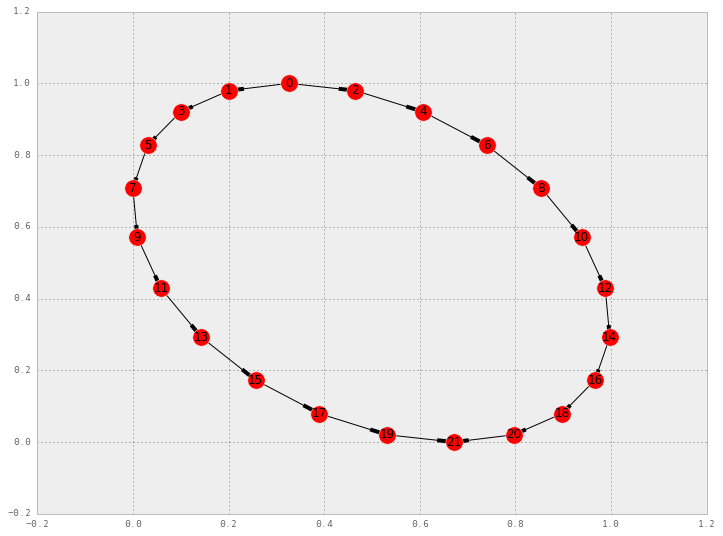

In [268]:
B = get_bubble_graph(10, 1, printGraph=True)

In [269]:
nx.write_gml(B, "gml/chain_path_10.gml")

In [270]:
results_clean_w1 = []
results_clean_w3 = []
results_clean_w100 = []
for n0 in range(7,33+1,4):
    results_clean_w1.append((n0, get_entropy_clean_bubble(n0, 1)))
    results_clean_w3.append((n0, get_entropy_clean_bubble(n0, 3)))
    results_clean_w100.append((n0, get_entropy_clean_bubble(n0, 100)))

NameError: name 'get_entropy_clean_bubble' is not defined

A entropia do caminho cresce linearmente a medida que o número de nós na bolha aumenta. O número de nós numa bolha pode ser relacionado ao tamanho do k-mer usado na construção do grafo já que SNPs formam bolhas contendo k-mer nós + 2 (nó junção inicial e nó fechamento). Essa afirmação só é válida para bolhas limpas (clean bubbles).

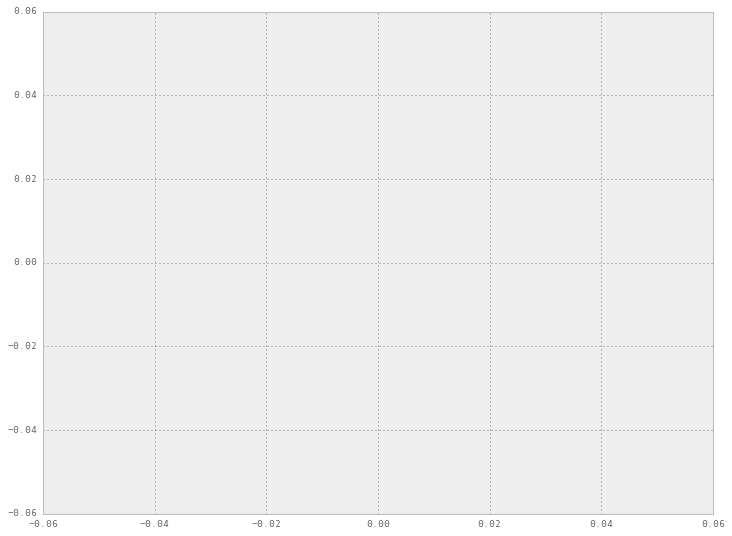

In [271]:
size_bubbles_w1 = [s[0] for s in results_clean_w1]
entropy_bubbles_w1 = [e[1] for e in results_clean_w1]

size_bubbles_w3 = [s[0] for s in results_clean_w3]
entropy_bubbles_w3 = [e[1] for e in results_clean_w3]

size_bubbles_w100 = [s[0] for s in results_clean_w100]
entropy_bubbles_w100 = [e[1] for e in results_clean_w100]

plt.plot(size_bubbles_w1, entropy_bubbles_w1)
plt.plot(size_bubbles_w3, entropy_bubbles_w3)
plt.plot(size_bubbles_w3, entropy_bubbles_w100)

In [272]:
np.array(entropy_bubbles_w1)-np.array(entropy_bubbles_w3)

array([], dtype=float64)

Rascunhando cálculos determinei a centralidade do nó da primeira bifurcação, $i$, denominado $C_H(i)$ equivalendo à expressão,

$C_H(i) = \frac{(outDegree(i)\ast N + 1)}{outDegree(i)} $,

com $N$ sendo o número de nós entre as bifurcações para todos os pesos de arestas iguais a 1 (sem peso).

**TODO:** descobrir a diferença entre a entropia do caminho com peso igual a 1 e os caminhos com peso W.

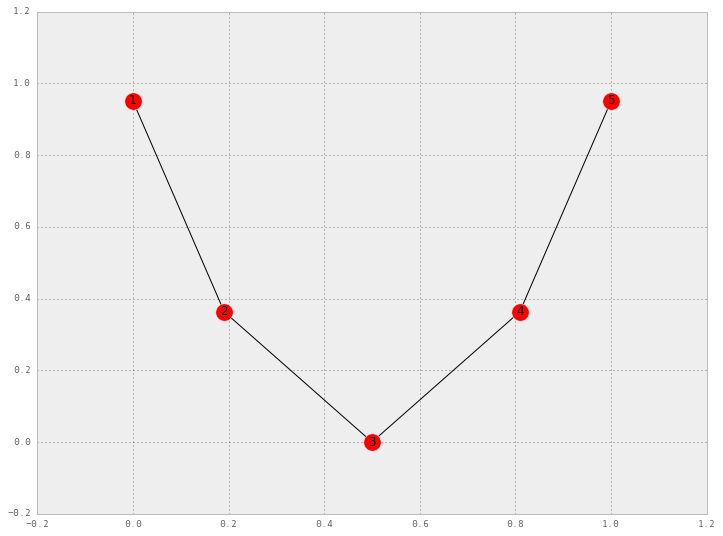

In [273]:
G_VI = nx.Graph()
G_VI.add_edge(1,2)
G_VI.add_edge(2,3)
G_VI.add_edge(3,4)
G_VI.add_edge(4,5)


pos = nx.spectral_layout(G_VI)
nx.draw_networkx(G_VI, pos=pos)

In [274]:
def replace_nodes(G0, Ns, N0):
    G0.add_node(N0, X="X")

    head = Ns[0]
    tail = Ns[-1]
    
    p = G0.predecessors(Ns[0])
    if len(p) == 1:
        p = p[0]
        G0.add_edge(p, N0)
        
    n = G0.successors(Ns[-1])
    if len(n) == 1:
        n = n[0]
        G0.add_edge(N0, n)
    
    G0.remove_nodes_from(Ns)

def reduce_graph(G0):
    G1 = G0.copy()
    G2 = G0.copy()
    nodes_to_remove = []
    for n in G1.nodes():
        if len(G1.successors(n)) > 1 or len(G1.predecessors(n)) > 1:
            if n[0] != "^" and n[-1] != "$":
                nodes_to_remove.append(n)
    G1.remove_nodes_from(nodes_to_remove)

    for ns in nx.weakly_connected_components(G1):
        #ns = [n for n in ns if n[0] != "^" and n[-1] != "$"]
        #ns = [n for n in ns if n[0] != "^" and n[-1] != "$"]
        if len(ns) == 0: continue
        contig = []
        n_sorted = nx.topological_sort(G1, ns)
        #n_sorted = [n for n in n_sorted if n[0] != "^" and n[-1] != "$"]
        print "NS:",n_sorted
        if len(n_sorted) <= 1: continue

        for kmer in n_sorted:
            assert len(G1.successors(kmer)) <= 1
            if len(contig) == 0:
                contig.append(kmer)
            else:
                contig.append(kmer[-1])
        replace_nodes(G2, n_sorted, "".join(contig))
        
    return G2

14
------------
ACGTCG
CGGCAC
CGTCGG
GGCACA
TCGGCA
GTCGGC
------------
graph GB
------------
14
------------
TCTGCA
CTGCAC
ACGTCT
GTCTGC
TGCACA
CGTCTG
NS: ['ACGTCT', 'CGTCTG', 'GTCTGC', 'TCTGCA', 'CTGCAC', 'TGCACA']
NS: ['ACGTCG', 'CGTCGG', 'GTCGGC', 'TCGGCA', 'CGGCAC', 'GGCACA']
NS: ['CACATC', 'ACATCG', 'CATCG$']
NS: ['^TACAC', 'TACACG', 'ACACGT']
6


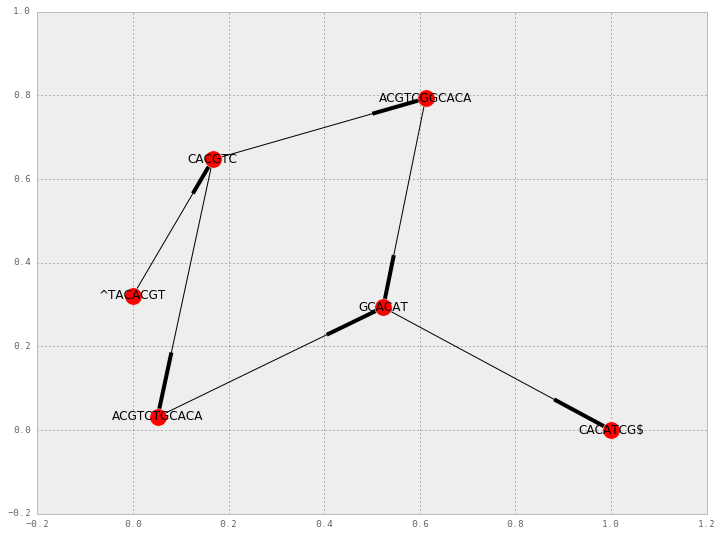

In [275]:
GA = buildDBG(["TACACGTCGGCACATCG"], 7)
GB = buildDBG(["TACACGTCTGCACATCG"], 7)
print len(nx.nodes(GA))
print "------------"
for nA in nx.nodes(GA):
    if nA not in nx.nodes(GB):
        print nA
print "------------"        
print "graph GB"
print "------------"
print len(nx.nodes(GB))
print "------------"
for nB in nx.nodes(GB):
    if nB not in nx.nodes(GA):
        print nB
        
GC = buildDBG(["TACACGTCGGCACATCG","TACACGTCTGCACATCG"], 7, True)
print len(nx.nodes(GC))
pos = nx.spring_layout(GC)
nx.draw_networkx(GC, pos=pos)

In [276]:
len("TACACGTCGGCACATCG")

17

### Bonchev metric

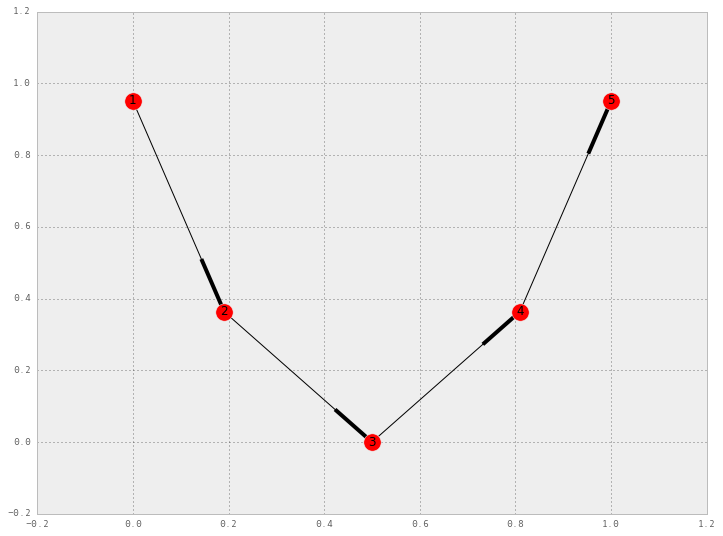

In [277]:
dG_VI = nx.DiGraph()
dG_VI.add_edge(1,2)
dG_VI.add_edge(2,3)
dG_VI.add_edge(3,4)
dG_VI.add_edge(4,5)

pos = nx.spectral_layout(dG_VI)
nx.draw_networkx(dG_VI, pos=pos)

In [278]:
def entropy_bonchev_shannon(G):
    nVertices = len(nx.nodes(G))
    # print "Number of vertices: ",nVertices
    I_mean = 0
    M = {}
    dist_back = []
#     normalizing = (nVertices**2-nVertices)
    normalizing = nVertices*(nVertices-1)    #(N-1)N
    for node_i in nx.nodes(G):
        for node_j in nx.nodes(G):
            if node_j >= node_i:
                try:
                    dist = len(nx.shortest_path(G, source=node_i, target=node_j))-1
                except nx.NetworkXNoPath:
                    dist = 0
                # print "Dist (", node_i,",",node_j,") = ", dist
                if dist in dist_back:
                    M[dist] += 1
                else:
                    M[dist] = 1
                    dist_back.append(dist)
    for i in M.keys():
        if i != 0:
            # print "key: ",i
            #log_pi = np.log(M[i])-np.log(nVertices**2)
            #pi = np.exp(log_pi)
            pi = float(M[i])/normalizing
            I_mean -= pi * np.log2(pi)
    # print M
    return I_mean, M, normalizing

In [279]:
def add_selfedges(dG):
    dGout = dG.copy()
    for node in nx.nodes(dGout):
        dGout.add_edge(node, node)
    return dGout

def add_fake_source(dG):
    topological = nx.topological_sort(dG)
    fakeSource = -1
    source = topological[0]
    dG.add_edge(fakeSource, fakeSource)
    dG.add_edge(fakeSource, source)
    return dG

def von_entropy(dG, add_fake=False, normalize=False, add_self=False):
    dGfake = dG.copy()
    if (add_fake == True):
        dGfake = add_fake_source(dGfake)
        nNodes = len(nx.nodes(dGfake))-1
    else:
        nNodes = len(nx.nodes(dGfake))
    if (add_self == True):
        dGfake = add_selfedges(dGfake)
        nNodes = len(nx.nodes(dGfake))-1
    sumEls = 0
    for u,v in nx.edges(dGfake):
        if u != v:
           # print(u,"->",v)
            d_u_in = dGfake.in_degree(u)
            d_v_in = dGfake.in_degree(v)
            d_u_out = dGfake.out_degree(u)
            el = float(d_u_in)/(d_v_in*(d_u_out**2))
            sumEls += el
    if (add_fake == True):
        sumEls += (3./4)
    if (normalize == True):
        return ((1./(2*nNodes))*sumEls)
    else:
        nNodesSquare = nNodes ** 2
        return (1 - (1./nNodes) - ((1./(2*nNodesSquare))*sumEls))
    

In [280]:
dummy_linked_end = dG_VI.copy()
dummy_linked_end.add_edge(5,1)
von_entropy(dummy_linked_end)

0.7000000000000001

In [281]:
von_entropy(add_selfedges(dG_VI))

0.7825000000000001

In [282]:
von_entropy(dG_VI, add_fake=True)

0.7000000000000001

In [283]:
von_entropy(dG_VI, add_fake=True, normalize=False)

0.7000000000000001

In [284]:
von_entropy(dG_VI, add_fake=True, normalize=True)

0.5

In [285]:
von_entropy(dG_VI)

0.74

In [286]:
G_VII = nx.Graph()
G_VII.add_edge(1,2)
G_VII.add_edge(2,3)
G_VII.add_edge(3,5)
G_VII.add_edge(3,4)

G_VIII = nx.Graph()
G_VIII.add_edge(2,5)
G_VIII.add_edge(5,3)
G_VIII.add_edge(5,4)
G_VIII.add_edge(5,1)

In [287]:
from networkx.algorithms import isomorphism

G_I = nx.Graph()
G_I.add_edge(1,2)
# G_I.add_edge(2,3)
# G_I.add_edge(3,1)
G_I.add_edge(1,5)
G_I.add_edge(2,5)
G_I.add_edge(2,6)
G_I.add_edge(5,7)
G_I.add_edge(5,4)
G_I.add_edge(3,4)
G_I.add_edge(2,3)

G_B = nx.DiGraph()
G_B.add_edge(1,2)
G_B.add_edge(2,3)

def entropy_rashevsky(G_I, digraph=False):
    if digraph:
        GM = isomorphism.DiGraphMatcher(G_I, G_I)
    else:
        GM = isomorphism.GraphMatcher(G_I, G_I)
    nNodes = len(nx.nodes(G_I))
    numBig = 0
    for sets in list(GM.isomorphisms_iter()):
#         print "---------------"
#         print sets
#         print "---------------"
        num = 0
        for (key,value) in sets.iteritems():
            #if (key != value) and (key in nodes) and (value in nodes):
            if (key != value):
                num += 1
#         print "num: ", num
        if num > numBig:
            numBig = num
            result = sets
            #    nodes.remove(key)
            #    nodes.remove(value)
            #    print "(",key,value,")"
        #print "xxxxxxxxxxxxxxx"
    if numBig == 0:
        HR = np.log2(nNodes)
        return numBig, [], [], HR
    checked_nodes = []
    rr = []
    HR = 0
    for (key,value) in result.iteritems():
        if key not in checked_nodes:
            r = []
            if key != result[key]:
                checked_nodes.append(key)
                r.append(key)
                newKey = result[key]
                while(newKey != key):
                    checked_nodes.append(newKey)
                    r.append(newKey)
                    newKey = result[newKey]          
            else:
    #             HR -= (1./nNodes)*np.log2(1./nNodes)
                r.append(key)
            pi = float(len(r))/nNodes
            HR -= pi*np.log2(pi)
            rr.append(r)
    #         print "(",key,value,")"
    #         nodes.remove(key)
    #         try:
    #             nodes.remove(value)
    #         except ValueError:
    #             continue
    return numBig, result, rr, HR


Lets consider a chain of nodes with N vertices represented in a digraph. We're going to increase the chain's size up to 100 nodes jumping from 3 to 103 in 10 to simulate unitigs. After that we will compute the entropy using Rashevsky, Bonchev and Von Neumann measures.

In [288]:
x=1
G_c = nx.DiGraph()
size_graphs = []
entropy_rashevsky_values = []
entropy_bonchev_values = []
entropy_von = []
entropy_von_norm = []
for size in range(3, 103+1, 10):
    print "Construct chain size: ", size
    for i in range(x+1,size):
        G_c.add_edge(x,i)
        x+=1
        
    size_graphs.append(len(nx.nodes(G_c)))
    _, _, _, HR = entropy_rashevsky(G_c, digraph=True)
    HB, _, _ = entropy_bonchev_shannon(G_c)
    H_vn = von_entropy(G_c, add_fake=True, normalize=False)
    H_vn_norm = von_entropy(G_c, add_fake=True, normalize=True)
    entropy_rashevsky_values.append(HR)
    entropy_bonchev_values.append(HB)
    entropy_von.append(H_vn)
    entropy_von_norm.append(H_vn_norm)

Construct chain size:  3
Construct chain size:  13
Construct chain size:  23
Construct chain size:  33
Construct chain size:  43
Construct chain size:  53
Construct chain size:  63
Construct chain size:  73
Construct chain size:  83
Construct chain size:  93
Construct chain size:  103


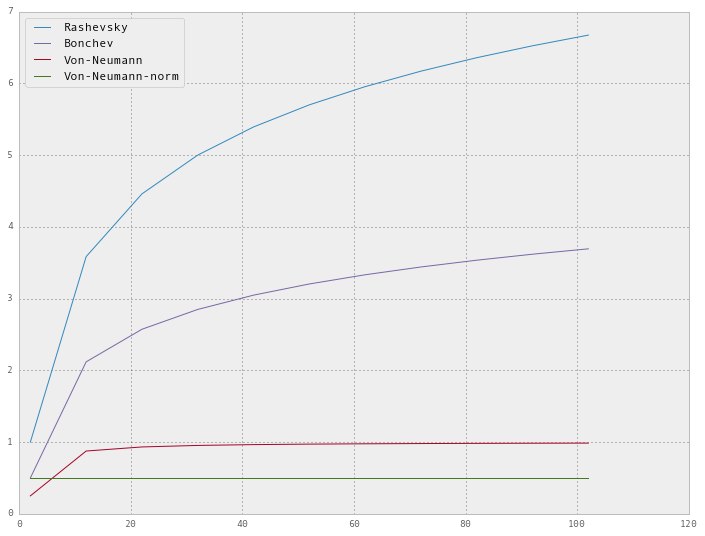

In [289]:
plt.plot(size_graphs, entropy_rashevsky_values, label='Rashevsky')
plt.plot(size_graphs, entropy_bonchev_values, label='Bonchev')
plt.plot(size_graphs, entropy_von, label='Von-Neumann')
plt.plot(size_graphs, entropy_von_norm, label='Von-Neumann-norm')
plt.legend(loc=2)

### Explorando non-clean bubbles

O exemplo explorado refere-se ao grafo mostrado na fig A.

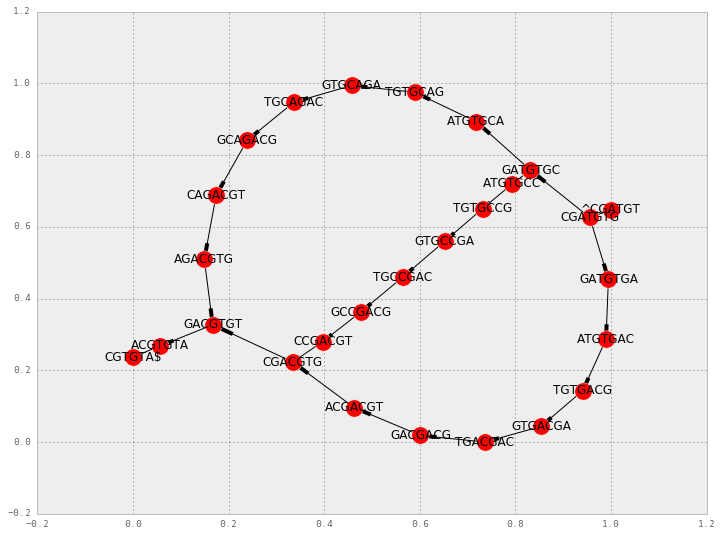

In [290]:
G_A = nx.DiGraph()
banish = ["TACACG", "ACACGT","ACATCG"]
for difpath in [dicSeqDummy1["links"],dicSeqDummy2["links"],dicSeqRef["links"]]:
    for edge in difpath:
        if ((edge["source"] not in banish) and (edge["target"] not in banish)):
            G_A.add_edge(edge["source"], edge["target"],weight=1)
pos = nx.spectral_layout(G_A)
nx.draw_networkx(G_A, pos=pos)
nx.write_gml(G_A, "gml/ex-A.gml")

NS: ['GATGTGA', 'ATGTGAC', 'TGTGACG', 'GTGACGA', 'TGACGAC', 'GACGACG', 'ACGACGT']
NS: ['ATGTGCA', 'TGTGCAG', 'GTGCAGA', 'TGCAGAC', 'GCAGACG', 'CAGACGT', 'AGACGTG']
NS: ['ATGTGCC', 'TGTGCCG', 'GTGCCGA', 'TGCCGAC', 'GCCGACG', 'CCGACGT']
NS: ['ACGTGTA', 'CGTGTA$']
NS: ['^CGATGT']


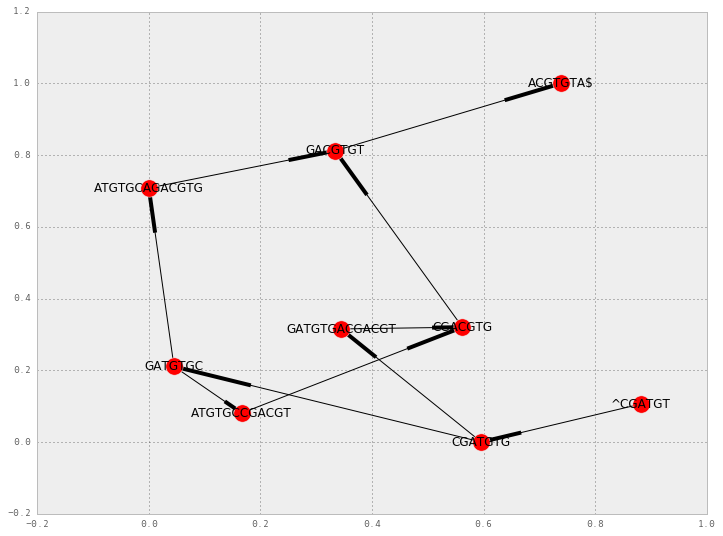

In [320]:
G_A_reduced = reduce_graph(G_A)
pos = nx.fruchterman_reingold_layout(G_A_reduced)
nx.draw_networkx(G_A_reduced, pos=pos)
nx.write_gml(G_A_reduced, "gml/ex-A-reduced.gml")

In [321]:
s_reduced_A,t_reduced_A = return_target_source(G_A_reduced)
t_reduced_A

['GACGTGT',
 'CGACGTG',
 'GACGTGT',
 'ATGTGCCGACGT',
 'ATGTGCAGACGTG',
 'GATGTGC',
 'GATGTGACGACGT',
 'CGACGTG',
 'ACGTGTA$',
 'CGATGTG']

In [322]:
i=0
labelsA = {}
for n in G_A_reduced.nodes():
    labelsA[n] = i
    i=i+1
labelsA

{'ACGTGTA$': 5,
 'ATGTGCAGACGTG': 2,
 'ATGTGCCGACGT': 6,
 'CGACGTG': 0,
 'CGATGTG': 4,
 'GACGTGT': 7,
 'GATGTGACGACGT': 1,
 'GATGTGC': 3,
 '^CGATGT': 8}

In [1]:
x = [[1,2],[1,3]]
for n in x:
    for k in x:
        print k

[1, 2]
[1, 3]
[1, 2]
[1, 3]


{'ACGTGTA$': <matplotlib.text.Text at 0x10ae3fa50>,
 'ATGTGCAGACGTG': <matplotlib.text.Text at 0x10ae3fe90>,
 'ATGTGCCGACGT': <matplotlib.text.Text at 0x10ae17bd0>,
 'CGACGTG': <matplotlib.text.Text at 0x10ae34090>,
 'CGATGTG': <matplotlib.text.Text at 0x10ae3f610>,
 'GACGTGT': <matplotlib.text.Text at 0x10ae344d0>,
 'GATGTGACGACGT': <matplotlib.text.Text at 0x10ae34910>,
 'GATGTGC': <matplotlib.text.Text at 0x10ae34d50>,
 '^CGATGT': <matplotlib.text.Text at 0x10ae3f1d0>}

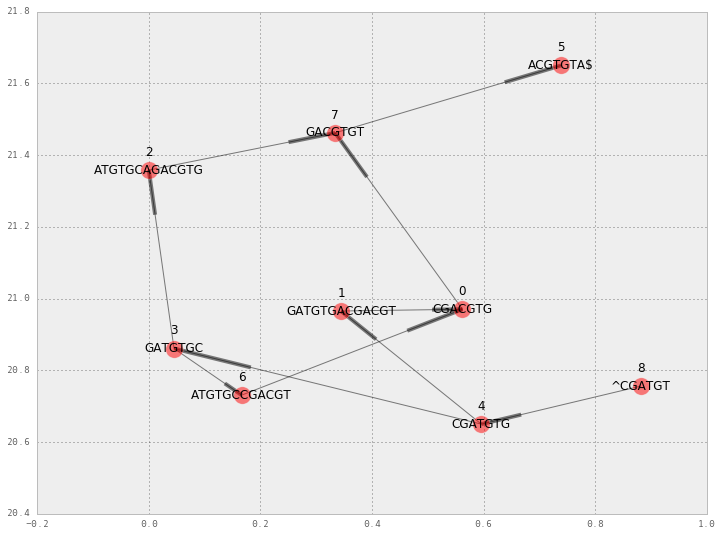

In [327]:
nx.draw_networkx(G_A_reduced, pos=pos, alpha=0.5)
for key,value in pos.iteritems():
    value[1] = value[1]+0.05
nx.draw_networkx_labels(G_A_reduced, pos, labelsA)

Declaramos uma função para imprimir os caminhos verdadeiros, dado o separation pair obtido na execução do getSeppairs. Caminhos verdadeiros porque a decomposição em 3-componentes não é feita em grafos diretos. Com isso, precisamos checar se existe um caminho que liga os dois pares separadores no grafo original.

In [377]:
def getTrueSplitPair(G, fseppairs):
    """
    O grafo usado como entrada no getSeppairs e o arquivo gerado <infixo>seppairs.txt
    contendo um separation pair por linha. Os dois nos que constituem o separation pair
    são separados por TAB.
    
    COMENTARIOS: como não há distinção na direção das arestas na construção das SPQR trees,
    devemos testar caminho nas duas direções. Isto é, do nó 1 do separation pair até nó 2 e vice-versa.
    
    
    OUTPUT: 
    """
    with open(fseppairs, 'r') as foseppairs:
        for line in foseppairs:
            no1, no2 = line.strip("\n").split("\t") #index dos nos no arquivo gml (inteiros)
            if (nx.has_path(G,G.nodes()[int(no1)], G.nodes()[int(no2)])): #index no grafo sao as labels
                print no1+"("+G.nodes()[int(no1)]+")"+"->"+no2+"("+G.nodes()[int(no2)]+")"
            # checando se existe o caminho reverso, ou seja, no2->no1
            elif (nx.has_path(G,G.nodes()[int(no2)], G.nodes()[int(no1)])):
                print no1+"("+G.nodes()[int(no2)]+")"+"->"+no2+"("+G.nodes()[int(no1)]+")"

Abaixo abrimos o arquivo contendo o indice dos nós formando _split pairs_ para checar se também são pares **source, sink**.

In [379]:
getTrueSplitPair(G_A_reduced, 
                 "/Users/rodtheo/Bioinfo/PROGRAMAS/marygold/metavar-code/src/getSeppairs/ex-A-reducedseppairs.txt")

0(GATGTGC)->3(CGACGTG)
0(CGATGTG)->4(CGACGTG)
3(GATGTGC)->7(GACGTGT)
4(CGATGTG)->7(GACGTGT)


Repare nos alinhamentos abaixo das três sequências:

3      TACACGTCTTCACATCG
1      TACACGTCGGCACATCG
2      TACACGTCTGCACATCG
       ********  *******
       


In [195]:
dG_X = nx.DiGraph()
dG_X.add_edge(1,2)
dG_X.add_edge(2,3)
dG_X.add_edge(3,4)
dG_X.add_edge(4,5)
dG_X.add_edge(5,6)
dG_X.add_edge(6,7)
dG_X.add_edge(7,8)
dG_X.add_edge(8,9)
#dG_X.add_edge(9,10)


In [196]:
von_entropy(G_A_reduced)

0.8675

In [197]:
def compute_dif_entropy(G):
    _, _, _, HR = entropy_rashevsky(G, digraph=True)
    HB, _, _ = entropy_bonchev_shannon(G)
    H_vn = von_entropy(G, add_fake=True, normalize=False)
    H_vn_norm = von_entropy(G, add_fake=True, normalize=True)
    return (HR, HB, H_vn, H_vn_norm)

In [198]:
GA_HR, GA_HB, GA_H_vn, GA_H_vn_norm = compute_dif_entropy(G_A)

In [199]:
GA_HR, GA_HB, GA_H_vn, GA_H_vn_norm

(4.7548875021634682,
 0.60075584563546858,
 0.9454732510288066,
 0.4722222222222222)

In [200]:
von_entropy(dG_X, add_fake=True, normalize=False), von_entropy(dG_X, add_fake=True, normalize=True)

(0.8333333333333333, 0.5)

**Exemplo B**

In [201]:
# "TACACGTCGGCACATCG","TACACGTCTGCACATCG","TACACGTCTTCACATCG"
# Check variant in position 9 -----** and a second variant in position 10 branching from two alleles (Dummy1 and Dummy3)
# The Dummy1 is colored in green and Dummy2 has black line while branching variants are dashed lines
dicSeqDummy1 = set_g_json("TACACGTCGGCACATCG",7, "licensing")
dicSeqDummy2 = set_g_json("TACACGTCTGCACATCG",7, "suit")
dicSeqRef =    set_g_json("TACACGTCGTCACATCG",7, "resolved")
dicSeqDummy3 = set_g_json("TACACGTCTTCACATCG",7, "resolved")

In [202]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
dataDummy3 = dicSeqDummy3['links']
dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2 + dataDummy3 + dataRef)

In [203]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div-B"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-B', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

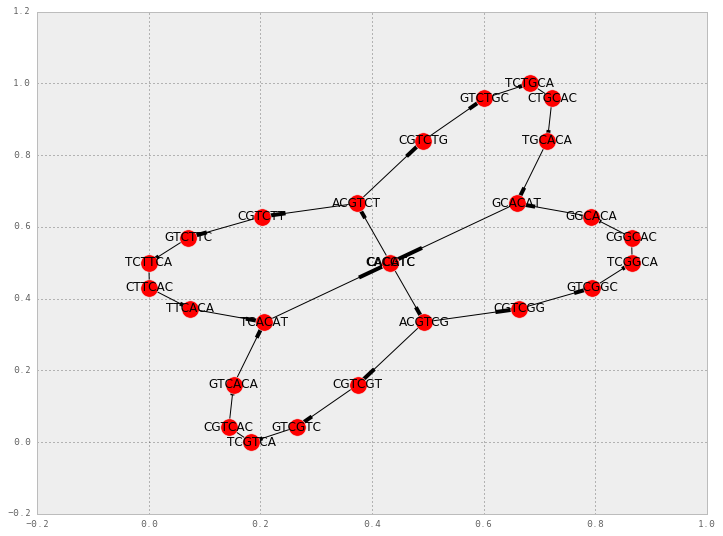

In [204]:
G_B = nx.DiGraph()
banish = ["TACACG","ACACGT","ACATCG"]
for difpath in [dicSeqDummy1["links"],dicSeqDummy2["links"],dicSeqRef["links"],dicSeqDummy3["links"]]:
    for edge in difpath:
        if ((edge["source"] not in banish) and (edge["target"] not in banish)):
            G_B.add_edge(edge["source"], edge["target"],weight=1)
pos = nx.spectral_layout(G_B)
nx.draw_networkx(G_B, pos=pos)
nx.write_gml(G_B, "gml/ex-B.gml")

['TCGTCA', 'CGTCAC', 'CGTCGT', 'GTCGTC', 'GTCACA']
['CGGCAC', 'GTCGGC', 'GGCACA', 'CGTCGG', 'TCGGCA']
['CTTCAC', 'CGTCTT', 'TCTTCA', 'TTCACA', 'GTCTTC']
['CGTCTG', 'TCTGCA', 'GTCTGC', 'CTGCAC', 'TGCACA']


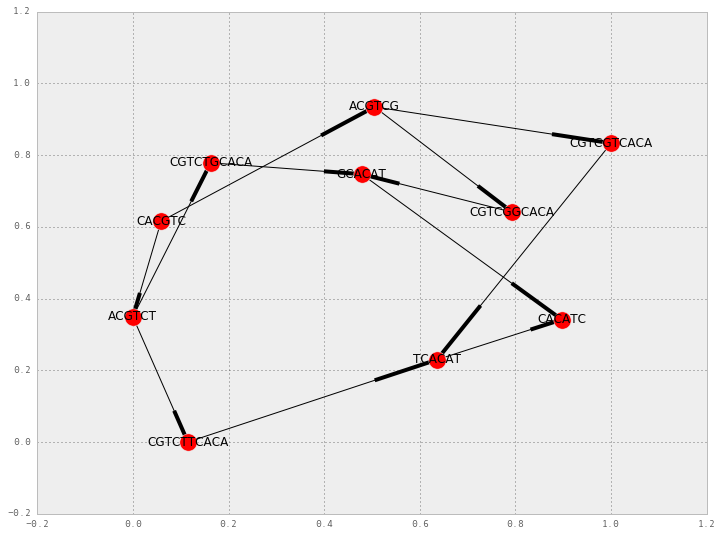

In [205]:
G_B_reduced = reduce_graph(G_B)
pos = nx.fruchterman_reingold_layout(G_B_reduced)
nx.draw_networkx(G_B_reduced, pos=pos)
nx.write_gml(G_B_reduced, "gml/ex-B-reduced.gml")

In [206]:
s_reduced_B,t_reduced_B = return_target_source(G_B_reduced)
s_reduced_B

['CGTCGGCACA',
 'CACGTC',
 'CACGTC',
 'ACGTCG',
 'ACGTCG',
 'GCACAT',
 'ACGTCT',
 'ACGTCT',
 'CGTCTTCACA',
 'CGTCGTCACA',
 'TCACAT',
 'CGTCTGCACA']

In [207]:
i=0
labels = {}
for n in G_B_reduced.nodes():
    labels[n] = i
    i=i+1
labels

{'ACGTCG': 3,
 'ACGTCT': 5,
 'CACATC': 1,
 'CACGTC': 2,
 'CGTCGGCACA': 0,
 'CGTCGTCACA': 7,
 'CGTCTGCACA': 9,
 'CGTCTTCACA': 6,
 'GCACAT': 4,
 'TCACAT': 8}

{'ACGTCG': <matplotlib.text.Text at 0x108607dd0>,
 'ACGTCT': <matplotlib.text.Text at 0x1079c6c90>,
 'CACATC': <matplotlib.text.Text at 0x1075eeb50>,
 'CACGTC': <matplotlib.text.Text at 0x108607f50>,
 'CGTCGGCACA': <matplotlib.text.Text at 0x1079c69d0>,
 'CGTCGTCACA': <matplotlib.text.Text at 0x1075ee910>,
 'CGTCTGCACA': <matplotlib.text.Text at 0x106953890>,
 'CGTCTTCACA': <matplotlib.text.Text at 0x108607b50>,
 'GCACAT': <matplotlib.text.Text at 0x1079c6d50>,
 'TCACAT': <matplotlib.text.Text at 0x106953e10>}

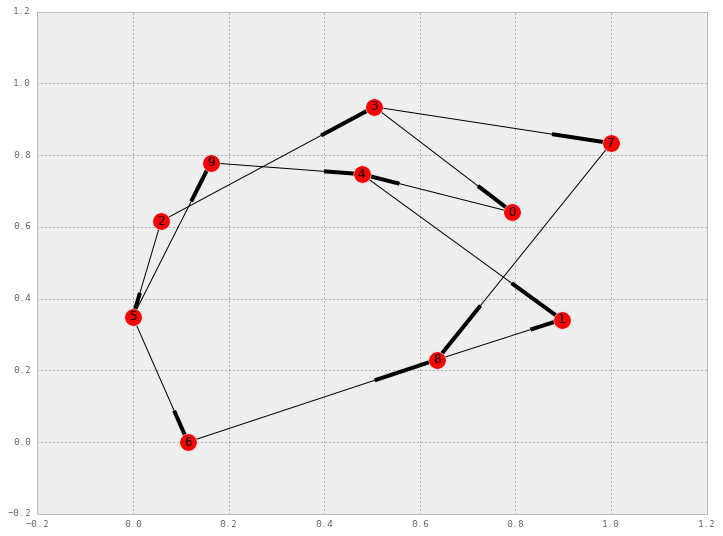

In [208]:
nx.draw_networkx(G_B_reduced, pos=pos, with_labels=False)
nx.draw_networkx_labels(G_B_reduced, pos, labels)

In [209]:
von_entropy(G_B_reduced)

0.875

In [210]:
GB_HR, GB_HB, GB_H_vn, GB_H_vn_norm = compute_dif_entropy(G_B)

In [211]:
GB_HR, GB_HB, GB_H_vn, GB_H_vn_norm

(3.7773627950641693, 0.7359654844915583, 0.944896449704142, 0.4326923076923077)

Exemplo **C**

In [212]:
# "TACACGTCGGCACATCG","TACACGTCTGCACATCG","TACACGTCTTCACATCG"
# Check variant in position 9 -----** and a second variant in position 10 branching from two alleles (Dummy1 and Dummy3)
# The Dummy1 is colored in green and Dummy2 has black line while branching variants are dashed lines
dicSeqDummy1 = set_g_json("TACACGTCGGCACATCG",7, "licensing")
dicSeqDummy2 = set_g_json("TACACGTCTGCACATCG",7, "suit")
dicSeqRef =    set_g_json("TACACGTCGTCACATCG",7, "resolved")
dicSeqDummy3 = set_g_json("TACACGTCTCCACATCG",7, "resolved")

In [213]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
dataDummy3 = dicSeqDummy3['links']
dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2 + dataDummy3 + dataRef)

In [214]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div-C"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-C', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

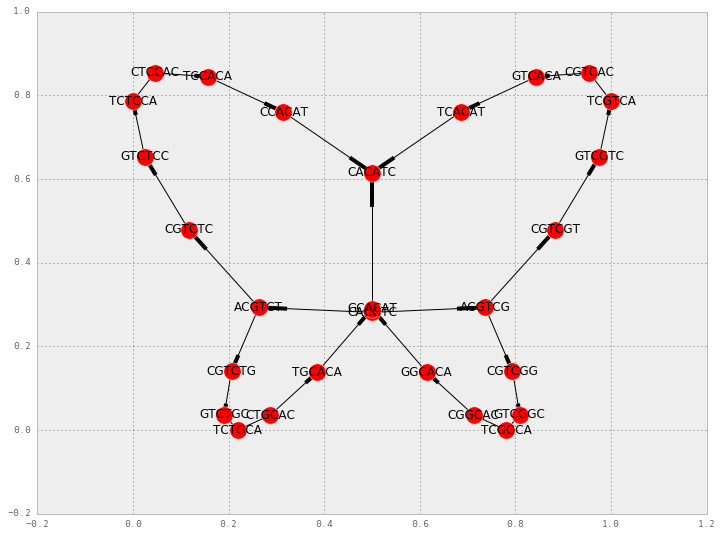

In [215]:
G_C = nx.DiGraph()
banish = ["TACACG","ACACGT","ACATCG"]
for difpath in [dicSeqDummy1["links"],dicSeqDummy2["links"],dicSeqRef["links"],dicSeqDummy3['links']]:
    for edge in difpath:
        if ((edge["source"] not in banish) and (edge["target"] not in banish)):
            G_C.add_edge(edge["source"], edge["target"],weight=1)
pos = nx.spectral_layout(G_C)
nx.draw_networkx(G_C, pos=pos)
nx.write_gml(G_C, "gml/ex-C.gml")

['TCGTCA', 'GTCGTC', 'GTCACA', 'CGTCGT', 'CGTCAC', 'TCACAT']
['CCACAT', 'TCTCCA', 'CTCCAC', 'TCCACA', 'GTCTCC', 'CGTCTC']
['CGGCAC', 'GTCGGC', 'GGCACA', 'CGTCGG', 'TCGGCA']
['CGTCTG', 'TCTGCA', 'GTCTGC', 'CTGCAC', 'TGCACA']


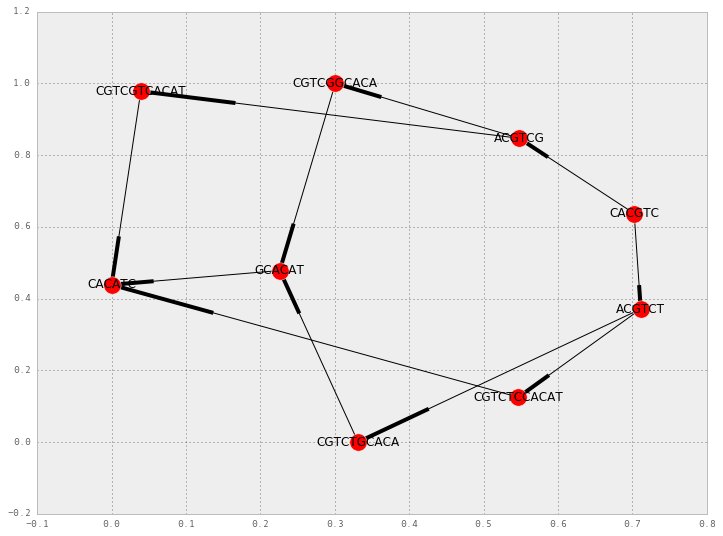

In [216]:
G_C_reduced = reduce_graph(G_C)
pos = nx.fruchterman_reingold_layout(G_C_reduced)
nx.draw_networkx(G_C_reduced, pos=pos)
nx.write_gml(G_C_reduced, "gml/ex-C-reduced.gml")

In [217]:
s_reduced_C,t_reduced_C = return_target_source(G_C_reduced)
t_reduced_C

['GCACAT',
 'ACGTCG',
 'ACGTCT',
 'CGTCGGCACA',
 'CGTCGTCACAT',
 'CACATC',
 'CGTCTGCACA',
 'CGTCTCCACAT',
 'GCACAT',
 'CACATC',
 'CACATC']

In [218]:
von_entropy(G_C_reduced)

0.868312757201646

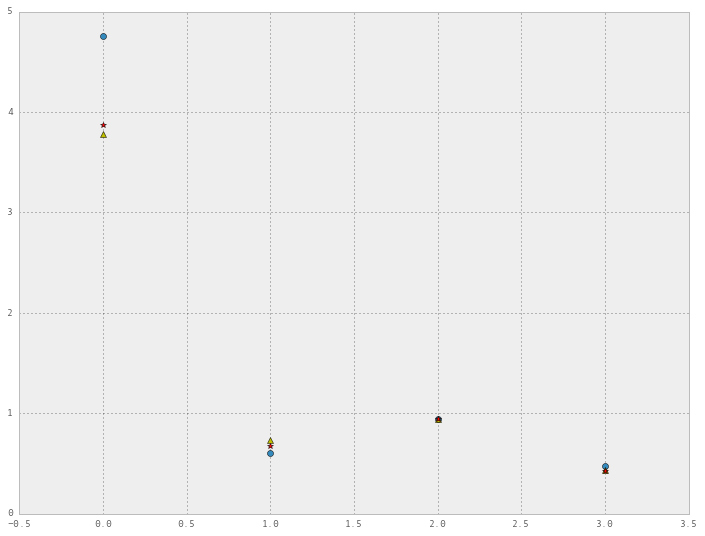

In [219]:
GC_HR, GC_HB, GC_H_vn, GC_H_vn_norm = compute_dif_entropy(G_C)
ax1 = plt.subplot()
ax1.set_xlim([-0.5,3.5])
ax1.plot([GA_HR, GA_HB, GA_H_vn, GA_H_vn_norm], 'o')
ax1.plot([GB_HR, GB_HB, GB_H_vn, GB_H_vn_norm], '^y')
ax1.plot([GC_HR, GC_HB, GC_H_vn, GC_H_vn_norm], '*r')

In [220]:
GC_HR, GC_HB, GC_H_vn, GC_H_vn_norm

(3.8659986132745803,
 0.67957451444413552,
 0.9473022405121171,
 0.42283950617283944)

## Complex SNP (bubble length < k)

In [221]:
dicSeqDummy1 = set_g_json("AATCGAGATAGA",5, "licensing")
dicSeqDummy2 = set_g_json("AATCGATATAGA",5, "suit")

In [222]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
#dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2)

In [223]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div-complex"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-complex', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

## SNPs + deletions in one bubble

Structure where two SNPs and one Deletion combine to form one bubble.

In [224]:
# MSA
# read1    CATCGTATGCTA---CAGG
# read2    CATCGCATGTTAGCTCAGG
#          ***** *** **   ****

In [225]:
dicSeqDummy1 = set_g_json("CATCGTATGCTACAGG",5, "licensing")
dicSeqDummy2 = set_g_json("CATCGCATGTTAGCTCAGG",5, "suit")

In [226]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
#dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2)

In [227]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div-indel1"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-indel1', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

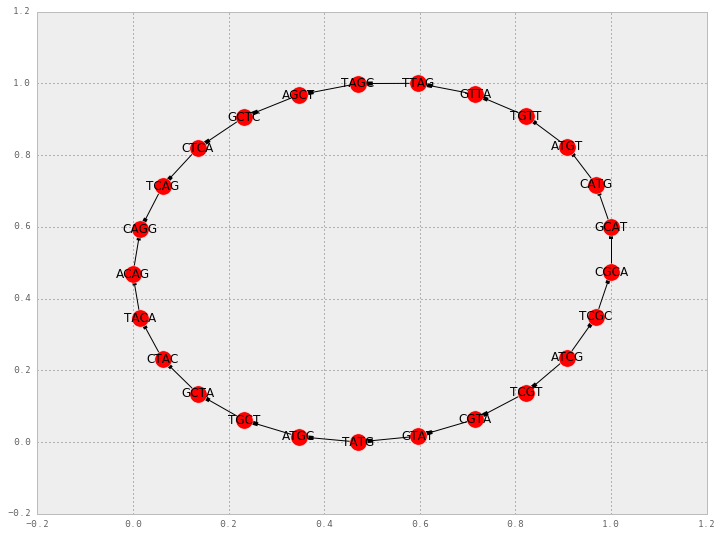

In [228]:
G_i = nx.DiGraph()
banish = ["CATC", "^CAT", "AGG$"]
for difpath in [dicSeqDummy1["links"],dicSeqDummy2["links"]]:
    for edge in difpath:
        if ((edge["source"] not in banish) and (edge["target"] not in banish)):
            G_i.add_edge(edge["source"], edge["target"],weight=1)
pos = nx.spectral_layout(G_i)
nx.draw_networkx(G_i, pos=pos)

['ACAG', 'ATGC', 'CTAC', 'TGCT', 'GCTA', 'TATG', 'GTAT', 'TACA', 'TCGT', 'CGTA']
['GTTA', 'CTCA', 'GCTC', 'CATG', 'TTAG', 'TCGC', 'TCAG', 'ATGT', 'TAGC', 'GCAT', 'AGCT', 'CGCA', 'TGTT']


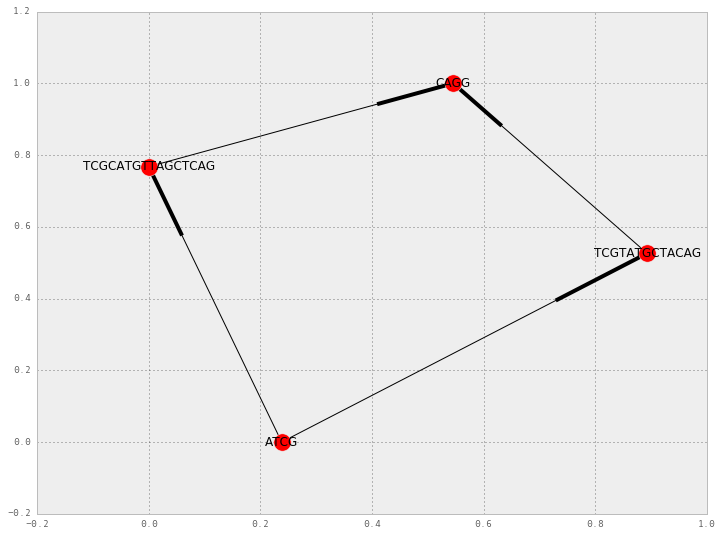

In [229]:
G_i_reduced = reduce_graph(G_i)
pos = nx.fruchterman_reingold_layout(G_i_reduced)
nx.draw_networkx(G_i_reduced, pos=pos)

In [230]:
von_entropy(G_i_reduced)

0.71875

In [231]:
Gi_HR, Gi_HB, Gi_H_vn, Gi_H_vn_norm = compute_dif_entropy(G_i)

In [232]:
Gi_HR, Gi_HB, Gi_H_vn, Gi_H_vn_norm

(4.6438561897747244,
 0.86763098737759259,
 0.9411999999999999,
 0.47000000000000003)

In [233]:
G_simpleBubble = get_bubble_graph(100, 1, printGraph=False)
Gs_HR, Gs_HB, Gs_H_vn, Gs_H_vn_norm = compute_dif_entropy(G_simpleBubble)

In [234]:
Gs_HR, Gs_HB, Gs_H_vn, Gs_H_vn_norm

(6.6681124728507886, 2.1221728944238727, 0.992592637976669, 0.4962871287128713)

Para o tamanho do path da clean-bubble maior que 100 os algoritmos de Rachevsky e Bonchev começam a apresentar esforço computacional considerável. Portanto, o calculo da entropia para P grande (> 100) vou me ater ao cálculo da entropia aproximada de Von Neumann.

In [235]:
graph_size = []
entropy_vn = []
entropy_vn_norm = []
entropy_vn_self = []
entropy_vn_true = []
for size in range(3, 103, 10):
    G_simpleBubble = get_bubble_graph(100, 1, printGraph=False)
    H_vn = von_entropy(G_simpleBubble, add_fake=True, normalize=False)
    H_vn_norm = von_entropy(G_simpleBubble, add_fake=True, normalize=True)
    H_vn_self = von_entropy(G_simpleBubble, add_fake=True, normalize=True, add_self=True)
    H_vn_true = von_entropy(G_simpleBubble)
    graph_size.append(size)
    entropy_vn.append(H_vn)
    entropy_vn_norm.append(H_vn_norm)
    entropy_vn_self.append(H_vn_self)
    entropy_vn_true.append(H_vn_true)

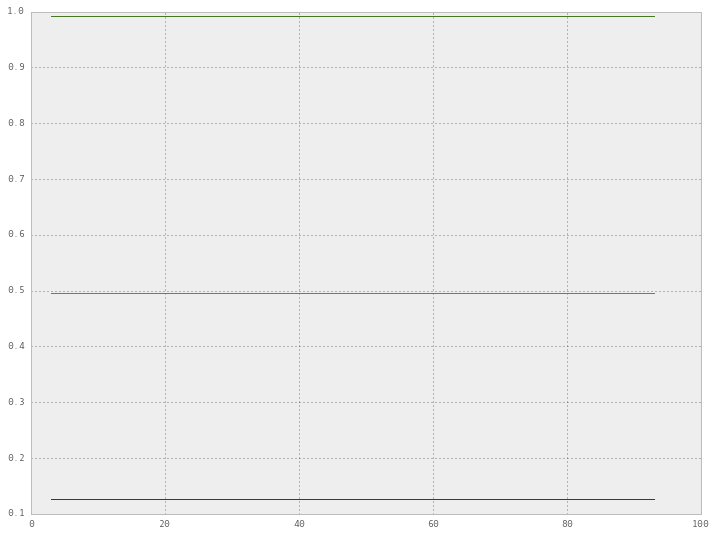

In [236]:
plt.plot(graph_size, entropy_vn)
plt.plot(graph_size, entropy_vn_norm)
plt.plot(graph_size, entropy_vn_self)
plt.plot(graph_size, entropy_vn_true)

In [237]:
from collections import deque
import numpy as np

G = nx.DiGraph()
G.add_edge(0,1)
G.add_edge(0,2)
G.add_edge(2,3)
G.add_edge(1,3)
# G.add_edge(1,0)
# G.add_edge(3,1)
# G.add_edge(0,2)
# G.add_edge(6,2)
# G.add_edge(2,3)
# G.add_edge(2,4)
# G.add_edge(3,2)
# G.add_edge()
# G.add_edge(1,3)
# G.add_edge(0,2)
# G.add_edge(2,3)

def bfs_marygold(G, s):
    orientation = "forward"
    marked = np.zeros(shape=(len(nx.nodes(G)),), dtype=int)
    marked[s] = 1
    print marked
    o1_line = 'for'
    Q = deque([G.edges(nbunch=s, data=True)])
    print Q
    while (len(Q) != 0):
        print "============================"
        v = Q.popleft()
        v_node = v[0][0]
        print "v = ", v
        print "for each edge(v, w)..."
        for edge in G.edges(nbunch=v_node, data=True):
            print "edge = ",edge
#             o1_line = edge[2]['ori'][0]
            print "o1' is ", o1_line
            print "if all edges incident..."
            for oriedges in G.edges(nbunch=v[1], data=True):
                print oriedges
#                 if oriedges != edge:
#                     o1 = oriedges[2]['ori'][1]
#                     o2 = oriedges[2]['ori'][0]
#                     print "o1 is ", o1, " and o2 is ", o2
#                     if (o2 == o1_line):
#                         print "o2 = o1' to edge ",oriedges
#                         print "Node ", oriedges[0], " marked is ", marked[oriedges[0]]
#                         if (marked[oriedges[0]] != 1):
#                             to_queue = 0
#                         else: 
#                             to_queue = 1
#             if (to_queue == 1):
#                 print "Queue item ", oriedges
#                 Q.append(oriedges[1])
            
                        
                            
                    
                        
                    
        
        

In [238]:
bfs_marygold(G, 0)

[1 0 0 0]
deque([[(0, 1, {}), (0, 2, {})]])
v =  [(0, 1, {}), (0, 2, {})]
for each edge(v, w)...
edge =  (0, 1, {})
o1' is  for
if all edges incident...
unhashable type: 'dict'

NetworkXError: Node {} in the sequence nbunch is not a valid node.

In [ ]:
G = nx.DiGraph()
G.add_edge(0,1)
G.add_edge(0,2)
G.add_edge(2,3)
G.add_edge(1,3)

G.edges(1)

In [ ]:
G = nx.DiGraph()
G.add_edge(10,1)
G.add_edge(1,2)
G.add_edge(2,5)
G.add_edge(1,3)
G.add_edge(3,1)
G.add_edge(3,5)
G.add_edge(5,3)
G.add_edge(1,4)
G.add_edge(4,5)
G.add_edge(5,11)
G.add_edge(10,6)
G.add_edge(6,7)
G.add_edge(7,12)
G.add_edge(12,8)
G.add_edge(6,8)
G.add_edge(7,9)
G.add_edge(8,9)
G.add_edge(9,11)


nx.write_gml(G, "spqr-tree-ex.gml")

In [ ]:
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx(G, pos=pos)